In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use("seaborn-v0_8")
sys.path.append("../")


# Demonstrating Our Synthetic Time Series Generation Framework

In this Notebook I demonstrate and analyze the synthetic time series generation framework from Pyraformer that we adapt. 

Overall logic, simply put, of the synthetic series is as follows:
 - Generate three sine waves that are functions of 24, 168, 720 (day, week, month for hourly data)<br> 
 - Length of the three waves is 17420 (two years for hourly data)<br>
 - Add the three sine waves to each other to get one sequence<br>
 - Add noise randomly sampled from Gaussian distribution<br> 
- - -

In [3]:
# Our extension of the time series synthesis function
from data_generator import SynthesisTS

# Helper function for descriptive stats and ADF
from data_generator import describe_and_test

# Define month and quarter as hourly ts -used for trends later on
month = 24 * 30
quarter = 24 * 30 * 3

## **1. Stationary Synthetic Time Series**

This is how the stationary time series we used in the presentation can 
be generated:

In [20]:
synth_maker = SynthesisTS(
    seq_len=17420,
    cycle_periods=[24, 168, 720],
    distort_cycles=None,
)

In [ ]:
# NOTE Re-running this will generate a slightly different
# (but in all characteristics the same) time series than the
# one shown below.
# This is due to us drawing noize terms randomly,
# and values of the series being shifted by +100 in a further update
# to accomodate trends without problems.
stationary = synth_maker.synthesize_single_series()

In [5]:
# Instead, you can import the sequence
STATIONARY_PATH = "../SYNTHDataset/SYNTHh.csv"
stationary = pd.read_csv(STATIONARY_PATH, index_col=0)

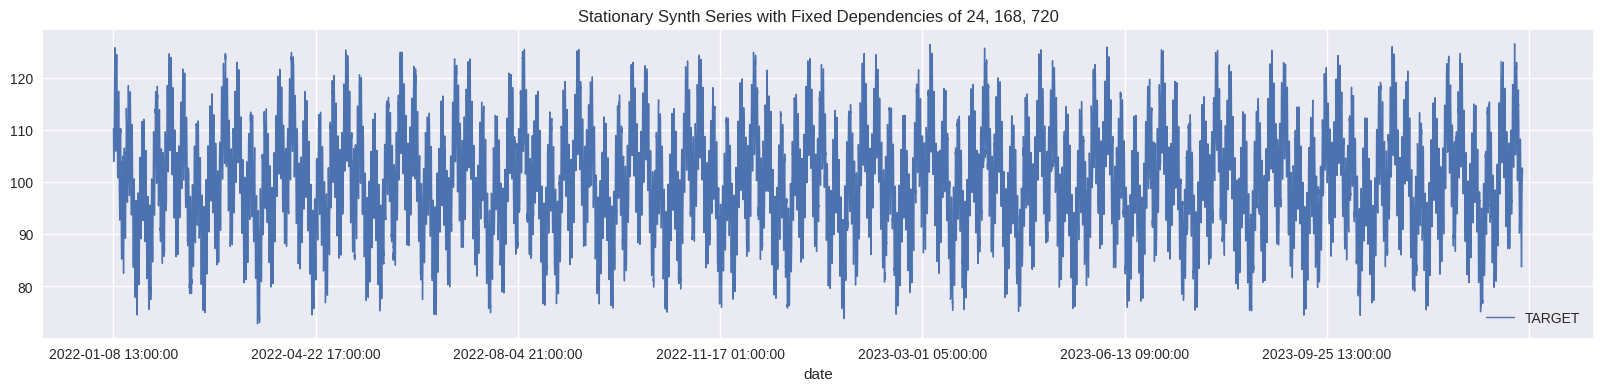

In [6]:
# Visualize
stationary.plot(lw=1, figsize=(20,4))
plt.title(
    "Stationary Synth Series with Fixed Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

Descriptive statistics shown below confirms that the series has a mean of 100 and st.dev. of 10, as it should be.
While it is obviously stationary, we also run a unit-root test below to confirm this.

In [ ]:
describe_and_test(stationary)

DESCRIPTIVE STATISTICS:
------------------------------------------------------------
             TARGET
count  17420.000000
mean     100.091765
std       10.620864
min       72.846092
25%       92.572499
50%      100.147829
75%      107.632463
max      126.546500
ADF TEST RESULTS:
------------------------------------------------------------
Test Statistic:  -15.4224
p-value:  0.0000
Null hypothesis of non-stationarity can be rejected.


## **1.1.1 Additive Trend**

In this section we demonstrate how additive trend is added the stationary time series. 
This is by just adding a trend slope that is constantly on the rise without reversals or breaks.

In [8]:
# Not really needed to re-initialize the class
synth_maker = SynthesisTS()

# Use the .add_additive_trend method added by us
additive = synth_maker.add_additive_trend(
    df=stationary,
    trend_slope=0.01,
    reversal=False,
)

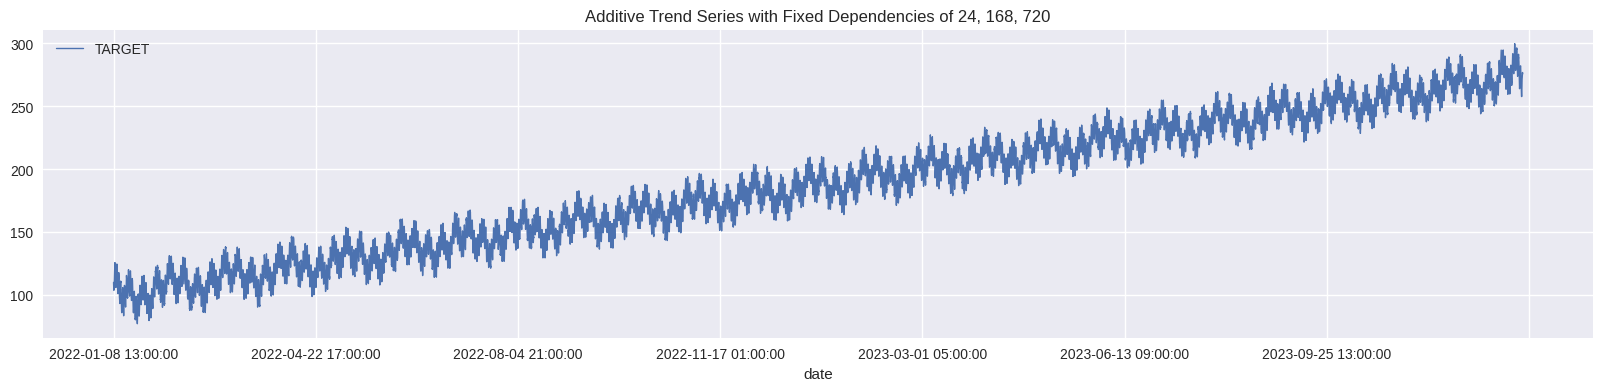

In [9]:
# Plot
additive.plot(lw=1, figsize=(20,4))
plt.title(
    "Additive Trend Series with Fixed Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

## **1.1.2 Additive Trend with Reversals**

Below we demonstrate adding arbitrarily picked reversal points with the additive trend.

In [23]:
# Here we the additive trend with reversals as follows
additive_reversal_new = synth_maker.add_additive_trend(
    df=stationary,
    trend_slope=0.02,
    reversal=True,
    reversal_timepoints=[
        quarter,
        quarter + (month),
        quarter * 2,
        quarter * 2 + (month + month // 2),
        quarter * 3,
        quarter * 4,
        (quarter * 5 + month // 3),
        (quarter * 6 - month - month // 2),
        quarter * 6,
        quarter * 6 + month,
        quarter * 7,
        quarter * 7 + month * 2,
    ],
    accumulated_retain_rate=1,
    trend_slope_increment=0.005
)


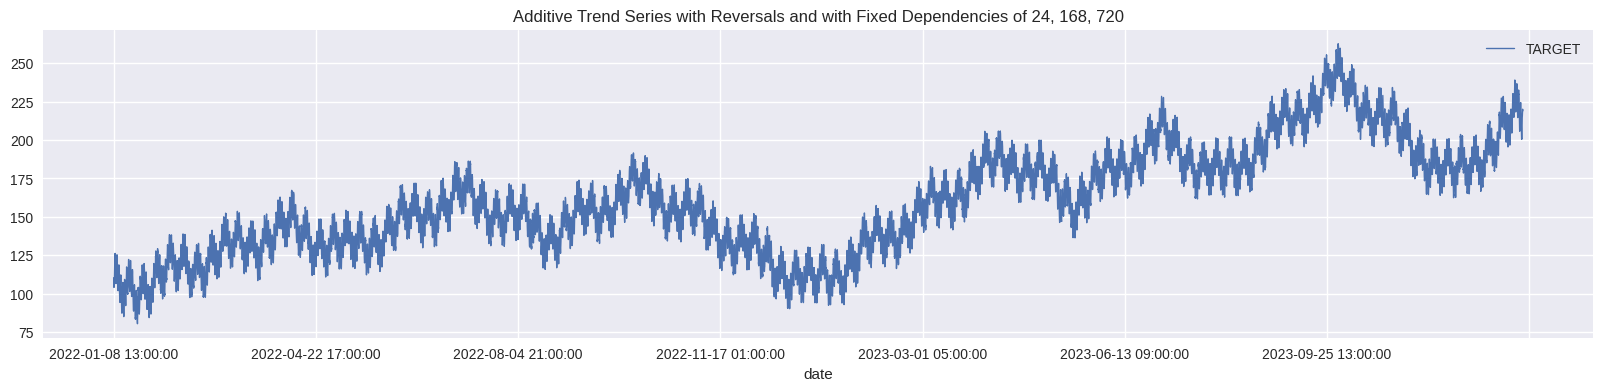

In [24]:
# Plot
additive_reversal_new.plot(lw=1, figsize=(20,4))
plt.title(
    "Additive Trend Series with Reversals and with Fixed Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

## **1.2.1 Multiplicative Trend**

Below we demonstrate adding a multiplicative trend to an existing series.

In [26]:
# Add the multiplicative trend to the stationary series
multiplicative = synth_maker.add_multiplicative_trend(
    df=stationary,
    reversal=False,  # no reversal
    trend_rate=1.00008,  # multiplicative trend rate
)

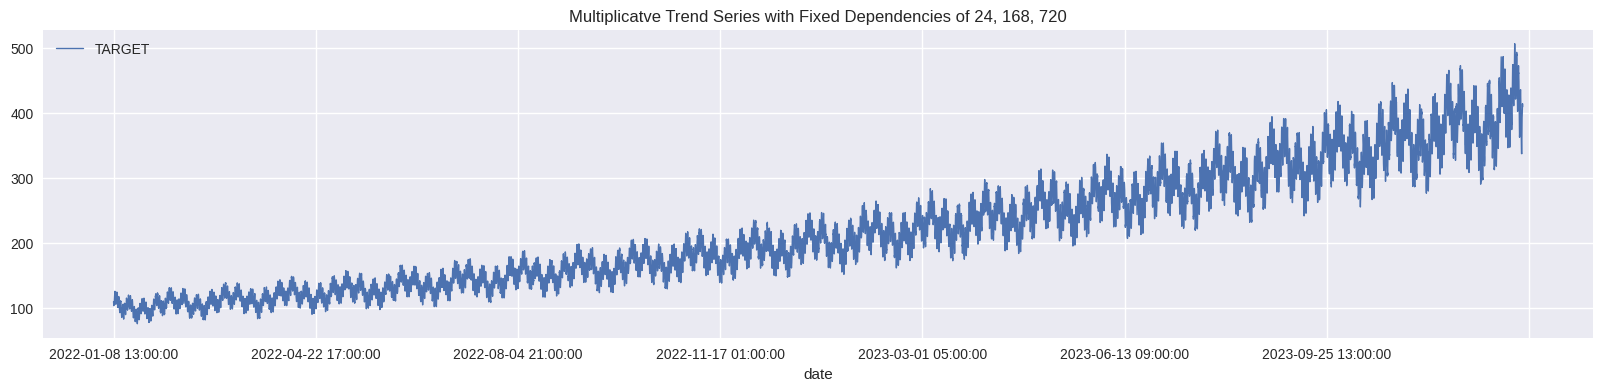

In [27]:
# Plot
multiplicative.plot(lw=1, figsize=(20,4))
plt.title(
    "Multiplicatve Trend Series with Fixed Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

## **1.2.2 Multiplicative Trend with Reversals**

Again, in the case of the multiplicative series, we make sure not to have regular reversal intervals by defining arbitrary ranges.

In [34]:
# Use the multiplicative trend method
multiplicative_reversal_new = synth_maker.add_multiplicative_trend(
    df=stationary,
    reversal=True,
    trend_rate=1.00008,
    reversal_offset=0.00002,
    reversal_timepoints=[
        quarter,
        quarter + month // 4,
        quarter * 4,
        quarter * 4 + month * 2 + (month // 2),
        quarter * 6,
        quarter * 6 + month // 4,
        quarter * 6 + month,
        quarter * 6 + month * 2,
        quarter * 7,
        quarter * 7 + month // 6,
        quarter * 7 + month,
        quarter * 8 - month,
    ],
)

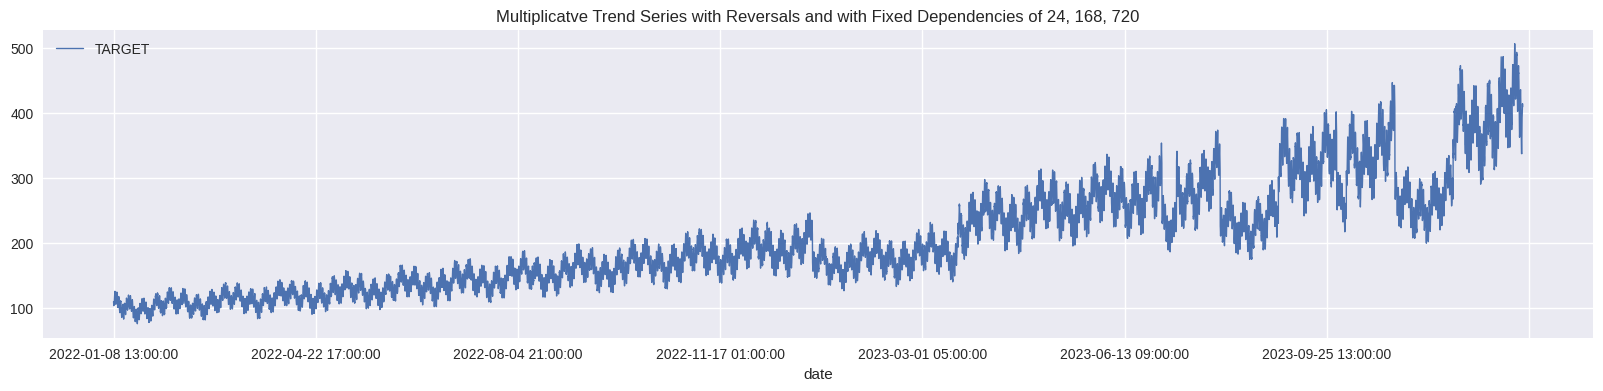

In [35]:
# Plot
multiplicative_reversal_new.plot(lw=1, figsize=(20,4))
plt.title(
    "Multiplicatve Trend Series with Reversals and with Fixed Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

## **2. Modified Stationary Time Series**

Below is the additional, distorted synthetic series that was not included experiments yet but shows promise for further research:

The aim was to somehow vary the time dependencies instead of having them fixed at 24, 168, 720.

To somehow distort these dependencies without losing them completely, we took an approach of defining ranges around these values.
In the source code, you can see we call this `distortion_cycles`, which are defined to be around 24, 168 and 720.

In the example below we use ranges of [(23, 25), (144, 168), (24 * 26, 24 * 32)].
What we then do, is instead of generating sine functions of 24, 168 and 720 and summing them, we generate sine waves for each integer in the ranges and take average within ranges.

For example, as a result, isntead of having the first sine function with parameter of 24, we now have three sine waves with 23, 24, 25. We take the average of these and obtain first sine wave to use in the linear combination. Then we generate sine waves with parameters 144, with 145, $\ldots$ 168. Take the average, move to the next range. At the end we sum up the three averaged sequences to obtain a series where these dependencies are distorted.

In [ ]:
# Re-initialize the SynthesisTS class
synth_maker = SynthesisTS(
    seq_len=17420,
    cycle_periods=[24, 168, 720],
    distort_cycles=[(23, 25), (144, 168), (24*26, 24*32)],  # ranges
)

In [ ]:
# NOTE rerunning will create a slightly different series
# as we draw random noize to add for every timestep
stationary_distorted = synth_maker.synthesize_single_series()

In [3]:
# Instead, you can import
DISTORTED_PATH = "../SYNTHDataset/SYNTH_distorted.csv"
stationary_distorted = pd.read_csv(DISTORTED_PATH, index_col=0)

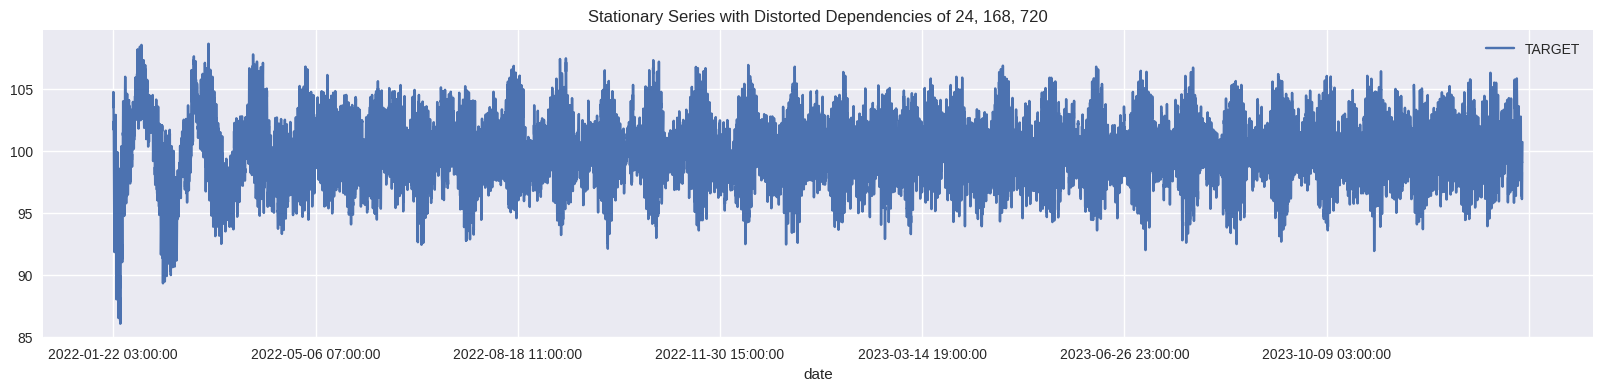

In [4]:
# Plot
stationary_distorted.plot(figsize=(20,4))
plt.title(
    "Stationary Series with Distorted Dependencies of 24, 168, 720"
)
plt.show()
plt.close()

The series is still stationary:

In [43]:
describe_and_test(stationary_distorted)

DESCRIPTIVE STATISTICS:
------------------------------------------------------------
             TARGET
count  17420.000000
mean      99.949959
std        2.686790
min       86.092723
25%       98.115284
50%       99.958383
75%      101.816940
max      108.661252
ADF TEST RESULTS:
------------------------------------------------------------
Test Statistic:  -8.6313
p-value:  0.0000
Null hypothesis of non-stationarity can be rejected.
